# Identificar subtipos de células sanguíneas a partir de imagens
* Basophil vs Eosinophil vs Lymphocyte vs Monocyte vs Neutrophil
* Mononuclear (Basophil + Lymphocyte vs Monocyte) vs Polynuclear (Neutrophil + Eosinophil)

Um problema importante no diagnóstico de sangue é a classificação de diferentes tipos de células sanguíneas. Aqui temos 410 imagens originais e 12.500 imagens aumentadas de células sanguíneas pareadas com rótulos de subtipo (Basófilo vs Eosinófilo vs Linfócito vs Monócito vs Neutrófilo). Queremos classificar automaticamente cada imagem de acordo com o subtipo de células dentro dela.

Para obter mais informações sobre células sanguíneas e subtipos de células sanguíneas, consulte os seguintes links:
https://www.ncbi.nlm.nih.gov/books/NBK2263/ e https://www.ncbi.nlm.nih.gov/books/NBK2263/box/A26/?report=objectonly

**Conectando ao Drive**

In [1]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 18.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importando Bibliotecas**

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as ET
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.optimizers import RMSprop
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, ReLU, ZeroPadding2D
from keras.utils import np_utils
from random import randint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from glob import glob
from distutils.dir_util import copy_tree, remove_tree
import sklearn
import itertools
import cv2
import scipy
import os
import csv

**Plotar os Dados**

In [4]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}

**Descrever dados**

In [5]:
#reader = csv.reader(open('/content/drive/MyDrive/Colab Notebooks/Celulas Sanguineas/dataset2-master/dataset2-master/labels.csv'))
#next(reader)
#X3 = []
#y3 = []
#for row in reader:
#    label = row[2]
#    if len(label) > 0 and label.find(',') == -1:
#        y3.append(label)
#y3 = np.asarray(y3)
#encoder = LabelEncoder()
#encoder.fit(y3)
#encoded_y = encoder.transform(y3)
#counts = np.bincount(encoded_y)
#print(counts)
#fig, ax = plt.subplots()
#plt.bar(list(range(5)), counts)
#ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
#ax.set_ylabel('Counts')

Aqui você pode ver que com as imagens originais temos tamanhos de turmas desequilibrados. Em vez disso, usaremos as imagens aumentadas porque elas não têm mais tamanhos de classe desequilibrados devido ao oversampling

In [6]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/Celulas Sanguineas/dataset2-master/"
root_dir = "./"
test_dir = base_dir + "TEST/"
train_dir = base_dir + "TRAIN/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Conteudo diretorios:", os.listdir(work_dir))

Conteudo diretorios: ['EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE', 'NEUTROPHIL']


In [7]:
numberOfClass = len(glob(train_dir+"/*")) 
print("Número de Classes: ",numberOfClass)

Número de Classes:  4


In [8]:
WORK_DIR = './dataset/'

CLASSES = [ 'MONOCYTE',
            'EOSINOPHIL',
            'NEUTROPHIL',
            'LYMPHOCYTE']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [9]:
#Executando o aumento de imagem para ter mais amostras de dados
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 12436 images belonging to 4 classes.


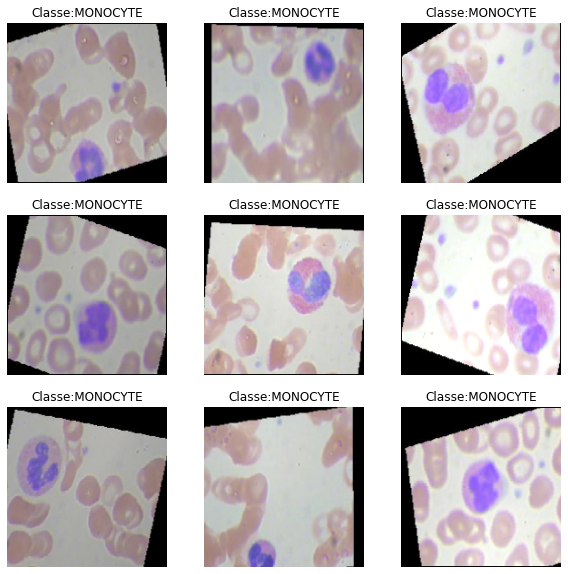

In [10]:
def show_images(generator,y_pred=None):
    
    # obter labels de imagem
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # obter um lote de imagens
    x,y = generator.next()
    
    # gera grade de 9 imagens
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 1698)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Classe:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    

show_images(train_data_gen)

In [11]:
# Recuperando os dados do iterador ImageDataGenerator
train_data, train_labels = train_data_gen.next()
# Conhecendo as dimensões do nosso conjunto de dados
print(train_data.shape, train_labels.shape)

(5936, 176, 176, 3) (5936, 4)


In [12]:
#Dividindo os dados em conjuntos de treinamento, teste e validação

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

**Callbacks**

In [13]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
METRICS = [
            tf.keras.metrics.BinaryAccuracy(name='acuracia'),
            tf.keras.metrics.Precision(name='precisão'),
            tf.keras.metrics.Recall(name='recall'),  
            tf.keras.metrics.AUC(name='auc'),
            f1_score
           ]

In [15]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.01 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 5) 

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

**Avaliar Modelos de Classificação**

In [16]:
def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc,precision, val_precision, recall, val_recall, f1, val_f1):
    
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize= (25,6))
    fig.suptitle(" Metricas do modelo ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Acuracia')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Acuracia')
    ax1.legend(['Treino', 'Teste'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Loss')
    ax1.legend(['Treino', 'Teste'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC')
    ax3.set_xlabel('Época')
    ax3.set_ylabel('AUC')
    ax1.legend(['Treino', 'Teste'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precisão')
    ax4.set_xlabel('Época')
    ax4.set_ylabel('Precisão')
    ax1.legend(['Treino', 'Teste'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('Recall')
    ax5.set_xlabel('Época')
    ax5.set_ylabel('Recall')
    ax1.legend(['Treino', 'Teste'])
    
    ax6.plot(range(1, len(f1) + 1), f1)
    ax6.plot(range(1, len(val_f1) + 1), val_f1)
    ax6.set_title('F1-score')
    ax6.set_xlabel('Época')
    ax6.set_ylabel('F1-score')
    ax1.legend(['Treino', 'Teste'])


    plt.show()

In [27]:
#CRIANDO MODELO
input_shape = (176, 176, 3)
model = Sequential()

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=input_shape, strides=1))
model.add(BatchNormalization())
model.add(ReLU())
model.add(ZeroPadding2D())
#model.add(Conv2D(128, (3,3)))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3)))

model.add(Conv2D(64, (3,3)))

model.add(BatchNormalization())
model.add(ReLU())
model.add(ZeroPadding2D())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))

model.add(Conv2D(32, (3,3)))

model.add(BatchNormalization())
model.add(ReLU())
model.add(ZeroPadding2D())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))

model.add(Conv2D(32, (3,3)))

model.add(BatchNormalization())
model.add(ReLU())
model.add(ZeroPadding2D())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.5))

model.add(Conv2D(64, (3,3)))

model.add(Conv2D(32, (3,3)))

model.add(BatchNormalization())
model.add(ReLU())
model.add(ZeroPadding2D())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.5))

model.add(Flatten())

#model.add(Sequential())
#model.add(Sequential())
#model.add(Sequential())

model.add(Dense(numberOfClass, activation='softmax'))



#COMPILANDO MODELO
model.compile(optimizer='rmsprop',
            loss=tf.losses.CategoricalCrossentropy(),
            metrics=METRICS)

history = model.fit(train_data,
        train_labels,
        validation_data= (val_data, val_labels),
        epochs = 100,
        verbose = 1,
        callbacks=lr_scheduler
                    )

score = model.evaluate(test_data,test_labels, verbose=0)
print('\nKeras CNN #1C - acuracia:', score[1],'\n')

Epoch 1/100
119/119 [==============================] - 38s 282ms/step - loss: 1.0559 - acuracia: 0.7486 - precisão: 0.4967 - recall: 0.4272 - auc: 0.7959 - f1_score: 0.4919 - val_loss: 4.9060 - val_acuracia: 0.7232 - val_precisão: 0.4463 - val_recall: 0.4463 - val_auc: 0.6309 - val_f1_score: 0.4464 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - 31s 257ms/step - loss: 0.8309 - acuracia: 0.7556 - precisão: 0.5112 - recall: 0.5087 - auc: 0.8378 - f1_score: 0.5103 - val_loss: 0.7048 - val_acuracia: 0.7042 - val_precisão: 0.4084 - val_recall: 0.4084 - val_auc: 0.8134 - val_f1_score: 0.4084 - lr: 3.9811e-04
Epoch 3/100
119/119 [==============================] - 31s 257ms/step - loss: 0.5844 - acuracia: 0.8479 - precisão: 0.6962 - recall: 0.6951 - auc: 0.9220 - f1_score: 0.6956 - val_loss: 0.9174 - val_acuracia: 0.7768 - val_precisão: 0.5537 - val_recall: 0.5537 - val_auc: 0.8320 - val_f1_score: 0.5536 - lr: 1.5849e-04
Epoch 4/100
119/119 [==============================] 

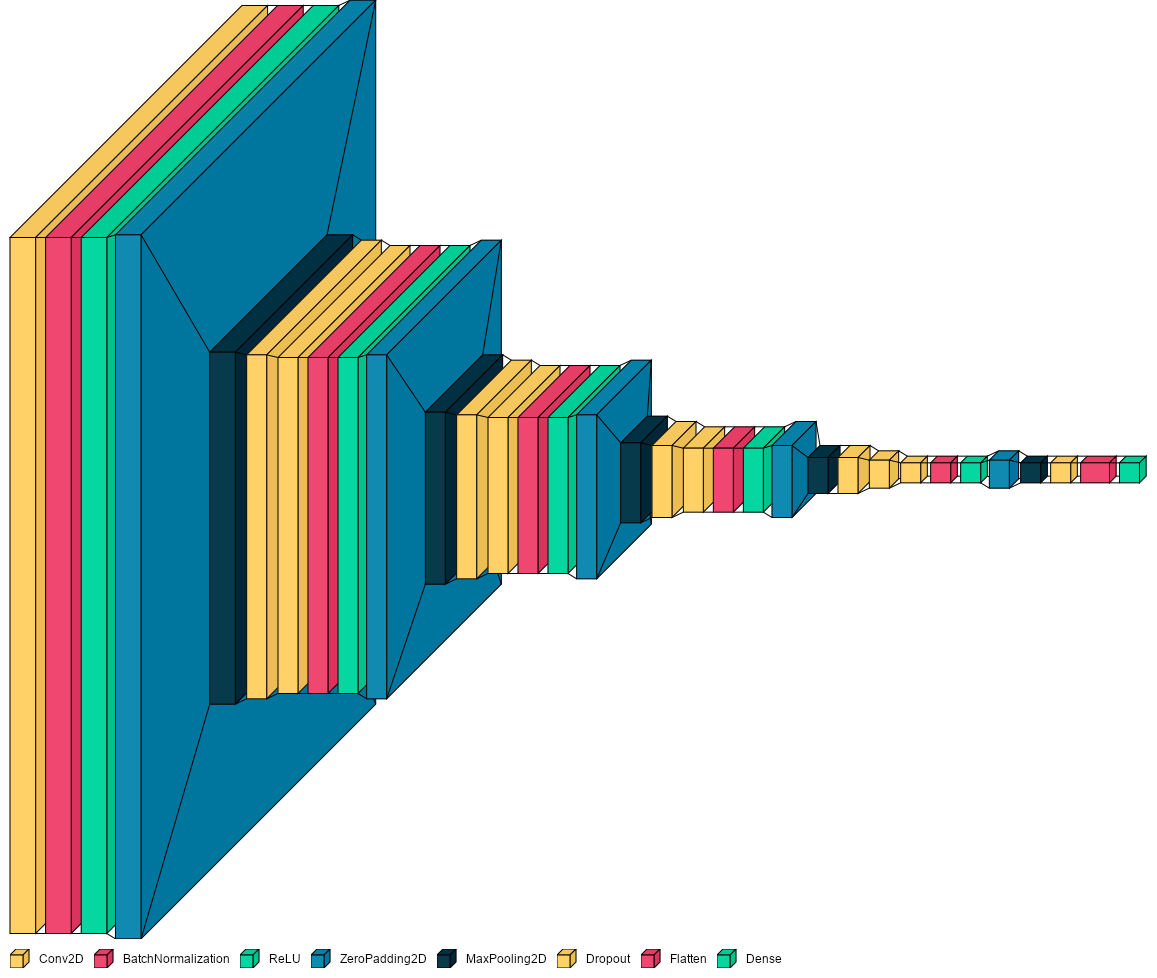

In [26]:
from PIL import ImageFont
import visualkeras 

font = ImageFont.truetype("/content/drive/MyDrive/Colab Notebooks/DATASET/arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font)

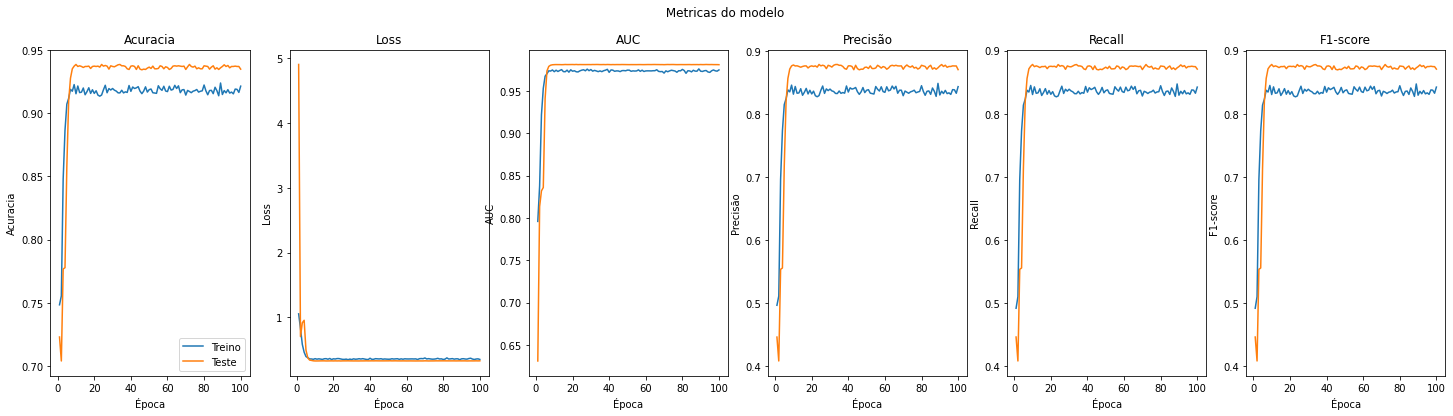

In [28]:
Train_Val_Plot(history.history['acuracia'],history.history['val_acuracia'],
            history.history['loss'],history.history['val_loss'],
            history.history['auc'],history.history['val_auc'],
            history.history['precisão'],history.history['val_precisão'],
            history.history['recall'],history.history['val_recall'],
            history.history['f1_score'],history.history['val_f1_score']
            )

In [29]:
test_scores = model.evaluate(test_data, test_labels)

print("Acuracia = ", test_scores[1])
print("Precisão = ", test_scores[2])
print("Recall = ", test_scores[3])
print("AUC = ", test_scores[4])
print("F1_score = ", test_scores[5])

38/38 [==============================] - 3s 71ms/step - loss: 0.3218 - acuracia: 0.9375 - precisão: 0.8772 - recall: 0.8721 - auc: 0.9844 - f1_score: 0.8659
Acuracia =  0.9375
Precisão =  0.8772227168083191
Recall =  0.872053861618042
AUC =  0.9844014644622803
F1_score =  0.8659122586250305
